In [1]:
%pwd

'/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/notebooks'

In [2]:
%cd ..

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization


In [3]:
# Import the models so we can follow the training code
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim

# Topology Library
import models
import problems
import topo_api
import topo_physics
import utils

%matplotlib inline

# Running neural structural optimization with torch 🔥 optimizers

To check the validity of our new `torch` based code we will test the structural optimization with `torch.optim` optimizers.

### MBB Beam

The first problem that we will run is with the **MBB BEAM**.

In [4]:
# Identify the problem
problem = problems.mbb_beam(height=20, width=60)

# Get the arguments for the problem
args = topo_api.specified_task(problem)

# Set up the cnn args for this problem
cnn_kwargs = dict(resizes=(1, 1, 2, 2, 1))

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/topo_api.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "forces": torch.tensor(problem.forces.ravel()),


In [5]:
# Initialize the model
model = models.CNNModel(
    args=args,
    **cnn_kwargs
)

# Get the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args['young'], poisson=args['poisson'],
)

# Set up the Adam optimizer - learning rate has already been adjusted
optimizer = optim.Adam(model.parameters(), lr=4e-3)

# In order to plot the frames and the losses we set up a list
# to append the results
frames = []
losses = []

# These keyword arguments were identified in the original code
kwargs = dict(
    penal=torch.tensor(args["penal"]),
    e_min=torch.tensor(args["young_min"]),
    e_0=torch.tensor(args["young"]),
)

# Put model in training mode
model.train()

for iteration, i in enumerate(range(500)):
    
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Model
    logits = model(None)
    
    # Calculate the physical density
    x_phys = topo_physics.physical_density(logits, args, volume_constraint=True)
    
    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)
    
    # Calculate the u_matrix
    u_matrix = topo_physics.displace(
        x_phys, ke, forces, args['freedofs'], args['fixdofs'], **kwargs
    )
    
    # Calculate the compliance output
    compliance_output = topo_physics.compliance(x_phys, u_matrix, ke, **kwargs)
    
    # The loss is the sum of the compliance
    loss = torch.sum(compliance_output)
    
    # Append the frames
    frames.append(logits)
    
    if (iteration % 10) == 0:
        print(f'Compliance loss = {loss.item()}')
        losses.append(loss.item())
    
    # Go through the backward pass and create the gradients
    loss.backward()

    # Step through the optimzer to update the data with the gradients
    optimizer.step()
    
# Render was also used in the original code to create images of the structures
render = [
    topo_physics.physical_density(x, args, volume_constraint=True)
    for x in frames
] 

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:67: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.h = args["nely"] // total_resize
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:68: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.w = args["nelx"] // tot

Compliance loss = 3055.8673053462635
Compliance loss = 427.30714329491303
Compliance loss = 392.24232682229933
Compliance loss = 374.1801106496539
Compliance loss = 355.6775017181385
Compliance loss = 333.3613034738451
Compliance loss = 311.3984182278274
Compliance loss = 283.6169227212897
Compliance loss = 256.2086572632378
Compliance loss = 237.59501168578885
Compliance loss = 226.82129658309708
Compliance loss = 219.30360967068776
Compliance loss = 213.97378553371493
Compliance loss = 210.57368868373402
Compliance loss = 207.9480605719118
Compliance loss = 205.57552494670097
Compliance loss = 203.68804105624227
Compliance loss = 202.20389629387049
Compliance loss = 201.176442495373
Compliance loss = 200.22343710452944
Compliance loss = 199.55626772183535
Compliance loss = 198.7546764007572
Compliance loss = 198.06324521816185
Compliance loss = 197.53111974205495
Compliance loss = 197.13337679423557
Compliance loss = 196.72099450687114
Compliance loss = 196.17285827301043
Compliance 

## Plot the structure 🌉

After our model is done training we can plot the final structure.

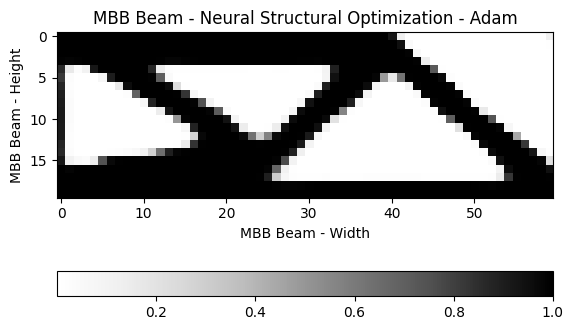

In [6]:
# Get the final frame
final_frame = render[-1].detach().numpy()

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Show the structure in grayscale
im = ax.imshow(final_frame, cmap='Greys')
ax.set_title('MBB Beam - Neural Structural Optimization - Adam')
ax.set_ylabel('MBB Beam - Height')
ax.set_xlabel('MBB Beam - Width')
fig.colorbar(im, orientation="horizontal", pad=0.2)

# Plot the loss trajectory ☄️

Finally, we will plot the loss directory for **compliance**

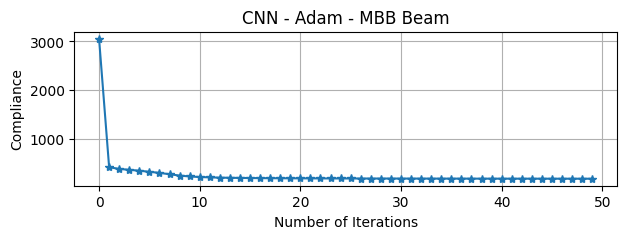

In [7]:
losses = pd.Series(losses)
ax = losses.plot(figsize=(7, 2), marker='*')
ax.set_title('CNN - Adam - MBB Beam')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Compliance')
ax.grid()